# HVAC optimization case study
## Exploration

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import save_fig

In [3]:
root_path = Path.cwd().parent
raw_data_path = root_path.joinpath("data/raw")
interim_data_path = root_path.joinpath("data/interim")
figure_path = root_path.joinpath("references/figures")

In [4]:
# use seabron styling for all plots
mpl.style.use("seaborn-colorblind")
mpl.rcParams.update({
    # set figure size to rotated A5 paper size for all plots
    "figure.figsize": (5.8, 4.1),
    "figure.titlesize": "large",
    "axes.labelsize": "medium",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.title_fontsize": "medium"})

In [5]:
# set figure size to A5 for all lineplots
figsize_line = (5.8, 8.3)
figsize_line_2cols = (14.5, 6)
figsize_line_2cols_large = (14.5, 12)

### Load data

In [6]:
train_df = pd.read_csv(raw_data_path.joinpath("datatraining.txt"))
train_df.name = "train"
test_df = pd.read_csv(raw_data_path.joinpath("datatest.txt"))
test_df.name = "test"
val_df = pd.read_csv(raw_data_path.joinpath("datatest2.txt"))
val_df.name = "valid"
dataframes = [train_df, test_df, val_df]

In [7]:
train_df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [8]:
test_df.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2800,2015-02-04 10:38:59,24.290000,25.700000,808.0,1150.25,0.004829,1
2801,2015-02-04 10:40:00,24.330000,25.736000,809.8,1129.20,0.004848,1
2802,2015-02-04 10:40:59,24.330000,25.700000,817.0,1125.80,0.004841,1
2803,2015-02-04 10:41:59,24.356667,25.700000,813.0,1123.00,0.004849,1
2804,2015-02-04 10:43:00,24.408333,25.681667,798.0,1124.00,0.004860,1


In [9]:
val_df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


### Apply basic transformations

In [10]:
for df in dataframes:
    df.columns = [col.lower() for col in df.columns]
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df.set_index(df.date, inplace=True)
    df.index = df.index.round("min")
    df.drop(columns=["date"], inplace=True)

### Save transformed data

In [11]:
for df in dataframes:
    df.to_csv(interim_data_path.joinpath(f"{df.name}_interim.csv"))

In [12]:
!ls -alh $interim_data_path

total 2984
drwxr-xr-x  6 stefan  staff   192B Mar 27 15:24 .
drwxr-xr-x  6 stefan  staff   192B Mar  9 12:48 ..
-rw-r--r--@ 1 stefan  staff   6.0K Mar 27 15:24 .DS_Store
-rw-r--r--  1 stefan  staff   182K Apr  6 12:13 test_interim.csv
-rw-r--r--  1 stefan  staff   542K Apr  6 12:13 train_interim.csv
-rw-r--r--  1 stefan  staff   653K Apr  6 12:13 valid_interim.csv


### Exploration

In [13]:
[print(df.name, df.info(), sep="\n") for df in dataframes]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    8143 non-null   float64
 1   humidity       8143 non-null   float64
 2   light          8143 non-null   float64
 3   co2            8143 non-null   float64
 4   humidityratio  8143 non-null   float64
 5   occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 445.3 KB
train
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2665 entries, 2015-02-02 14:19:00 to 2015-02-04 10:43:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    2665 non-null   float64
 1   humidity       2665 non-null   float64
 2   light          2665 non-null   float64
 3   co2            2665 non-null   float64
 4   humidityratio  2665 non-null   f

[None, None, None]

In [14]:
[print(df.name, df.describe(), sep="\n") for df in dataframes]

train
       temperature     humidity        light          co2  humidityratio  \
count  8143.000000  8143.000000  8143.000000  8143.000000    8143.000000   
mean     20.619084    25.731507   119.519375   606.546243       0.003863   
std       1.016916     5.531211   194.755805   314.320877       0.000852   
min      19.000000    16.745000     0.000000   412.750000       0.002674   
25%      19.700000    20.200000     0.000000   439.000000       0.003078   
50%      20.390000    26.222500     0.000000   453.500000       0.003801   
75%      21.390000    30.533333   256.375000   638.833333       0.004352   
max      23.180000    39.117500  1546.333333  2028.500000       0.006476   

         occupancy  
count  8143.000000  
mean      0.212330  
std       0.408982  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  
test
       temperature     humidity        light          co2  humidityratio  \
count  2665.000000  2665.000000  2665.0

[None, None, None]

In [15]:
[print(df.name, df.occupancy.value_counts(normalize=True), sep="\n") for df in dataframes]

train
0    0.78767
1    0.21233
Name: occupancy, dtype: float64
test
0    0.635272
1    0.364728
Name: occupancy, dtype: float64
valid
0    0.789889
1    0.210111
Name: occupancy, dtype: float64


[None, None, None]

In [16]:
[print(df.name,
       f"Days: {df.index.day.unique()}",
       f"Weekdays: {df.index.dayofweek.unique()}",
       f"Hours: {df.index.hour.unique()}", 
       f"Minutes: {df.index.minute.unique()}", 
       sep="\n") for df in dataframes]

train
Days: Int64Index([4, 5, 6, 7, 8, 9, 10], dtype='int64', name='date')
Weekdays: Int64Index([2, 3, 4, 5, 6, 0, 1], dtype='int64', name='date')
Hours: Int64Index([17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            10, 11, 12, 13, 14, 15, 16],
           dtype='int64', name='date')
Minutes: Int64Index([51, 52, 53, 54, 55, 56, 57, 58, 59,  0,  1,  2,  3,  4,  5,  6,  7,
             8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
            25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
            42, 43, 44, 45, 46, 47, 48, 49, 50],
           dtype='int64', name='date')
test
Days: Int64Index([2, 3, 4], dtype='int64', name='date')
Weekdays: Int64Index([0, 1, 2], dtype='int64', name='date')
Hours: Int64Index([14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,
             7,  8,  9, 10, 11, 12, 13],
           dtype='int64', name='date')
Minutes: Int64Index([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 

[None, None, None]

### Visualization

#### Count plots

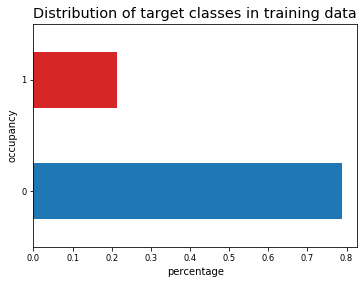

In [17]:
count_plot_train = train_df.occupancy.value_counts(normalize=True).plot(kind="barh", 
                                                                        title="Distribution of target classes in training data", 
                                                                        color=("tab:blue", "tab:red"))
count_plot_train.set_xlabel("percentage")
count_plot_train.set_ylabel("occupancy")

save_fig(count_plot_train, figure_path, "count_plot_train")

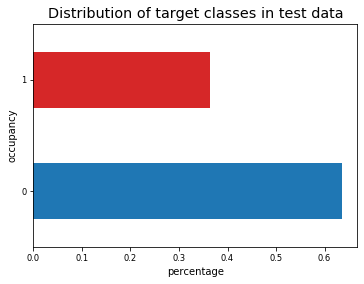

In [18]:
count_plot_test = test_df.occupancy.value_counts(normalize=True).plot(kind="barh", 
                                                                        title="Distribution of target classes in test data", 
                                                                        color=("tab:blue", "tab:red"))
count_plot_test.set_xlabel("percentage")
count_plot_test.set_ylabel("occupancy")

save_fig(count_plot_test, figure_path, "count_plot_test")

#### Correlation heatmap

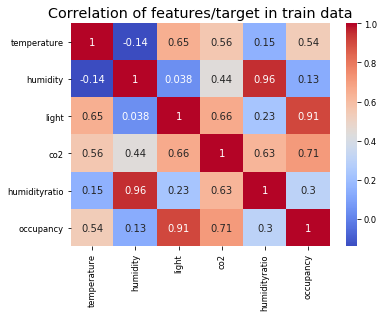

In [19]:
heatmap_train = sns.heatmap(data=train_df.corr(), cmap="coolwarm", annot=True).set_title("Correlation of features/target in train data")
save_fig(heatmap_train, figure_path, "heatmap_train")

#### Line plots

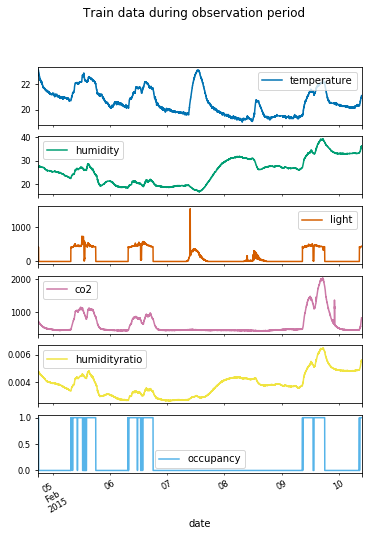

In [20]:
line_plot_train = train_df.plot(figsize=figsize_line, subplots=True, title="Train data during observation period")
save_fig(line_plot_train, figure_path, "line_plot_train")

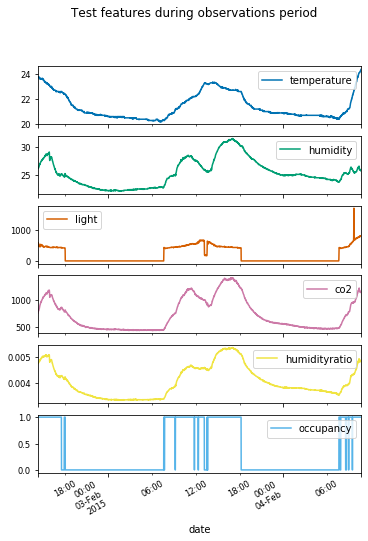

In [21]:
line_plot_test = test_df.plot(figsize=figsize_line, subplots=True, title="Test features during observations period")
save_fig(line_plot_test, figure_path, "line_plot_test")

#### Line plot 1h resample

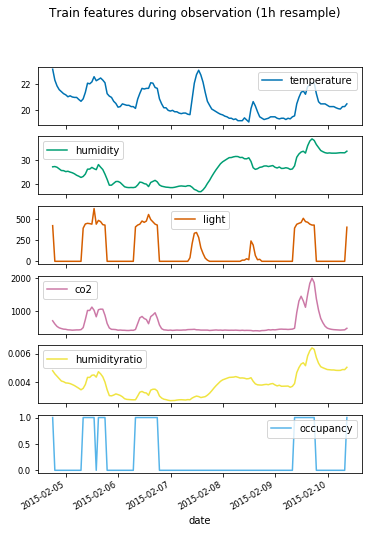

In [22]:
line_plot_train_1h_freq = train_df.asfreq(freq="1h").plot(
    figsize=figsize_line,
    subplots=True,
    title="Train features during observation (1h resample)")

save_fig(line_plot_train_1h_freq, figure_path, "line_plot_train_1h_freq")

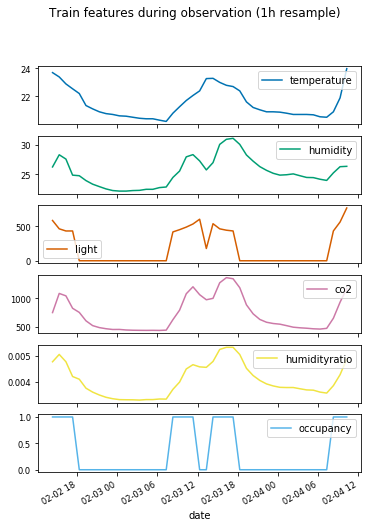

In [23]:
line_plot_test_1h_freq = test_df.asfreq(freq="1h").plot(
    figsize=figsize_line,
    subplots=True,
    title="Train features during observation (1h resample)")

save_fig(line_plot_test_1h_freq, figure_path, "line_plot_test_1h_freq")

#### Line plot by weekday

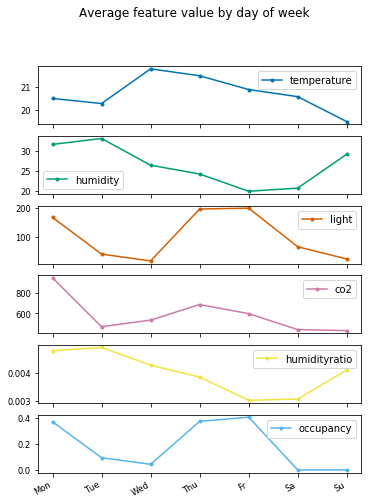

In [24]:
by_weekday = train_df.groupby(train_df.index.weekday).mean()
by_weekday.index = ["Mon", "Tue", "Wed", "Thu", "Fr", "Sa", "Su"]
by_weekday_plot = by_weekday.plot(figsize=figsize_line, 
                                  subplots=True, 
                                  marker=".",
                                  title="Average feature value by day of week")



save_fig(by_weekday_plot, figure_path, "avg_feature_by_weekday")

#### Line plot per hour

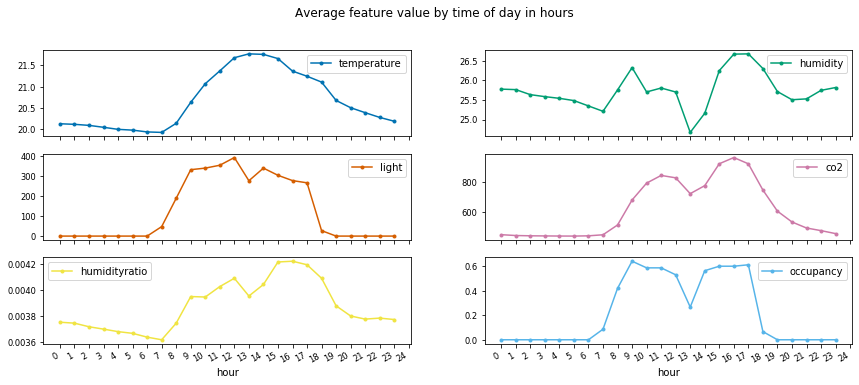

In [25]:
by_hour = train_df.groupby(train_df.index.hour).mean()
by_hour_plot = by_hour.plot(figsize=figsize_line_2cols,
                            layout=(3,2),
                            subplots=True, 
                            marker=".",
                            xticks=np.arange(0,24+1),
                            title="Average feature value by time of day in hours")


by_hour_plot[-1][0].set_xlabel("hour")
by_hour_plot[-1][-1].set_xlabel("hour")
save_fig(by_hour_plot, figure_path, "avg_feature_value_by_hour")

In [26]:
train_df["weekday"] = np.where(train_df.index.weekday < 5, "weekday", "weekend")
by_hour_weekend = train_df[train_df.weekday == "weekend"]
by_hour_weekday = train_df[train_df.weekday == "weekday"]

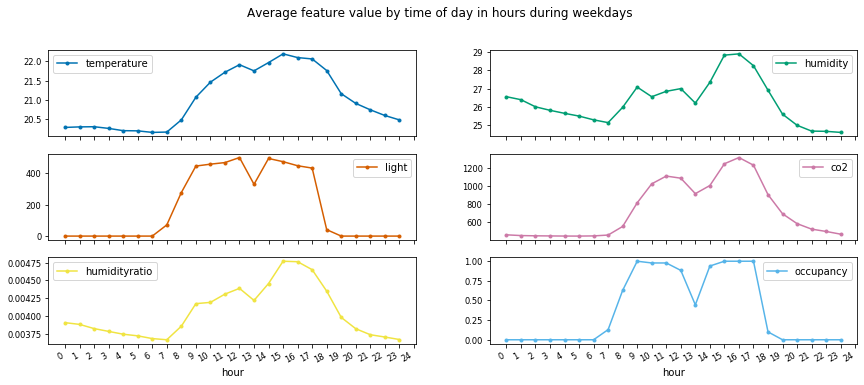

In [27]:
by_hour_weekday_plot = by_hour_weekday.groupby(by_hour_weekday.index.hour).mean().plot(
    figsize=figsize_line_2cols,
    layout=(3,2),
    subplots=True, 
    marker=".",
    xticks=np.arange(0,24+1),
    title="Average feature value by time of day in hours during weekdays")

by_hour_weekday_plot[-1][0].set_xlabel("hour")
by_hour_weekday_plot[-1][-1].set_xlabel("hour")
save_fig(by_hour_weekday_plot, figure_path, "avg_feature_value_by_hour_weekday")

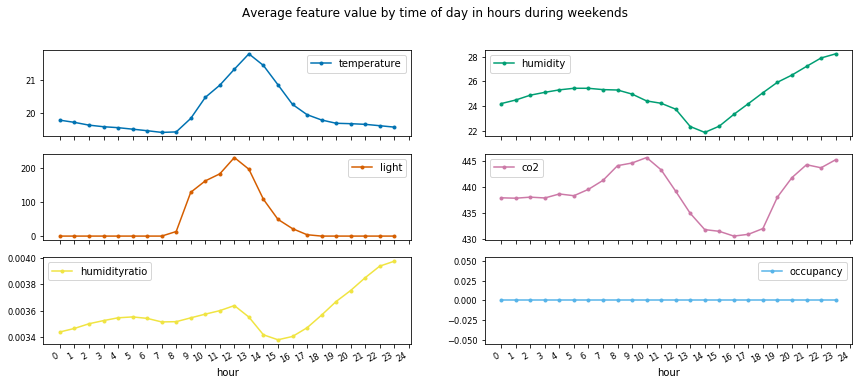

In [28]:
by_hour_weekend_plot = by_hour_weekend.groupby(by_hour_weekend.index.hour).mean().plot( 
                            figsize=figsize_line_2cols,
                            layout=(3,2),
                            subplots=True, 
                            marker=".",
                            xticks=np.arange(0,24+1),
                            title="Average feature value by time of day in hours during weekends")

by_hour_weekend_plot[-1][0].set_xlabel("hour")
by_hour_weekend_plot[-1][-1].set_xlabel("hour")
save_fig(by_hour_weekend_plot, figure_path, "avg_feature_value_by_hour_weekend")

In [29]:
by_hour_week_day_end = train_df.groupby([train_df.weekday, train_df.index.hour]).mean()

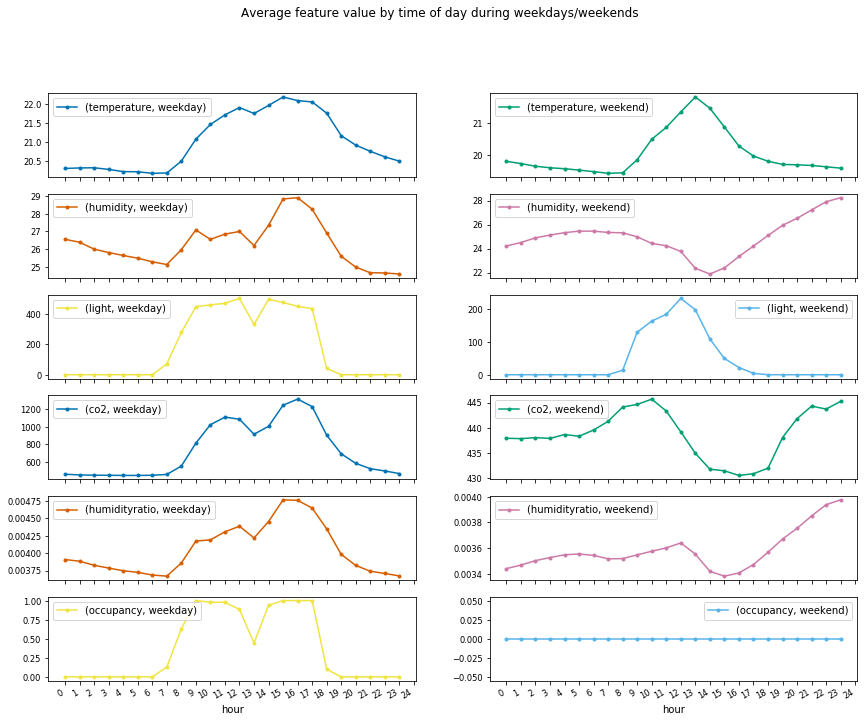

In [30]:
by_hour_week_day_end_plot = by_hour_week_day_end \
    .unstack(level=0) \
    .plot(subplots=True,
          figsize=figsize_line_2cols_large,
          layout=(6,2),
          marker=".",
          xticks=np.arange(0,24+1),
          title="Average feature value by time of day during weekdays/weekends")

by_hour_week_day_end_plot[-1][0].set_xlabel("hour")
by_hour_week_day_end_plot[-1][-1].set_xlabel("hour")
save_fig(by_hour_week_day_end_plot, figure_path, "avg_feature_value_by_hour_week_day_end")    